In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

In [2]:
df = pd.read_csv("florida_accidents.csv")

In [3]:
df.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [4]:
# Drop rows where Sunrise_Sunset is missing
df = df.dropna(subset=['Sunrise_Sunset'])

# Create the Twilight_Phase column
df['Twilight_Phase'] = (
    (df['Sunrise_Sunset'] == 'Night') &  
    ((df['Civil_Twilight'] == 'Day') | (df['Nautical_Twilight'] == 'Day') | (df['Astronomical_Twilight'] == 'Day'))
)

# Convert to binary (True/False) for simplicity
df['Twilight_Phase'] = df['Twilight_Phase'].astype(bool)

# Drop the original twilight-related columns
columns_to_drop = ['Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
df = df.drop(columns=columns_to_drop)

In [5]:
# Critical columns to keep
critical_columns = [
    'Severity', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 
    'Visibility(mi)', 'Precipitation(in)', 'Weather_Condition', 
    'Bump', 'Crossing', 'Junction', 'Stop', 'Traffic_Calming', 
    'Traffic_Signal', 'Sunrise_Sunset', 'Twilight_Phase', 'Give_Way', 'No_Exit', 'Railway', 'Roundabout', 'Station'
]

# Combine critical and optional columns
columns_to_keep = critical_columns

# Retain only the selected columns
df = df[columns_to_keep]

# Display the updated DataFrame information
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 875602 entries, 0 to 880191
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Severity           875602 non-null  int64  
 1   Distance(mi)       875602 non-null  float64
 2   Temperature(F)     861961 non-null  float64
 3   Humidity(%)        860324 non-null  float64
 4   Visibility(mi)     864344 non-null  float64
 5   Precipitation(in)  708081 non-null  float64
 6   Weather_Condition  865852 non-null  object 
 7   Bump               875602 non-null  bool   
 8   Crossing           875602 non-null  bool   
 9   Junction           875602 non-null  bool   
 10  Stop               875602 non-null  bool   
 11  Traffic_Calming    875602 non-null  bool   
 12  Traffic_Signal     875602 non-null  bool   
 13  Sunrise_Sunset     875602 non-null  object 
 14  Twilight_Phase     875602 non-null  bool   
 15  Give_Way           875602 non-null  bool   
 16  No_Exit

/var/folders/80/jbllx5qn3d73pyblcd_7_7800000gn/T/ipykernel_33574/1629278404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Severity', data=df, palette = "Set2")


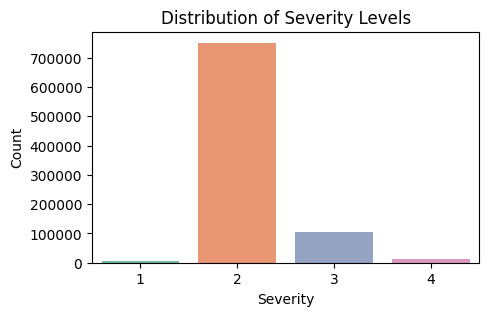

Severity Distribution (%):
 Severity
2    85.837058
3    11.867264
4     1.495885
1     0.799793
Name: proportion, dtype: float64


In [6]:
# Plot the distribution of the target variable
plt.figure(figsize=(5, 3))
sns.countplot(x='Severity', data=df, palette = "Set2")
plt.title('Distribution of Severity Levels')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()

# Calculate and display percentage distribution
severity_distribution = df['Severity'].value_counts(normalize=True) * 100
print("Severity Distribution (%):\n", severity_distribution)

In [7]:
# Check overall missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Combine into a single DataFrame for better visualization
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percentage (%)': missing_percentage
}).sort_values(by='Missing Percentage (%)', ascending=False)

print("Overall Missing Values Summary:")
print(missing_summary)

# Check missing values specifically for Severity 4
severity_2_missing = df[df['Severity'] == 2].isnull().sum()
severity_2_percentage = (severity_2_missing / len(df[df['Severity'] == 2])) * 100

severity_2_summary = pd.DataFrame({
    'Missing Values': severity_2_missing,
    'Missing Percentage (%)': severity_2_percentage
}).sort_values(by='Missing Percentage (%)', ascending=False)

print("\nMissing Values Summary for Severity 4:")
print(severity_2_summary)


Overall Missing Values Summary:
                   Missing Values  Missing Percentage (%)
Precipitation(in)          167521               19.132094
Humidity(%)                 15278                1.744857
Temperature(F)              13641                1.557900
Visibility(mi)              11258                1.285744
Weather_Condition            9750                1.113520
Severity                        0                0.000000
Sunrise_Sunset                  0                0.000000
Roundabout                      0                0.000000
Railway                         0                0.000000
No_Exit                         0                0.000000
Give_Way                        0                0.000000
Twilight_Phase                  0                0.000000
Stop                            0                0.000000
Traffic_Signal                  0                0.000000
Traffic_Calming                 0                0.000000
Distance(mi)                    0       

In [8]:
# Identify rows with missing values in critical columns
critical_columns_with_missing = ['Precipitation(in)', 'Humidity(%)', 'Temperature(F)', 'Visibility(mi)', 'Weather_Condition']

# Filter out rows where Severity == 2 and have missing values
severity_2_missing_filter = (df['Severity'] == 2) & (df[critical_columns_with_missing].isnull().any(axis=1))

# Drop these rows
df = df[~severity_2_missing_filter]

# Check overall missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Combine into a single DataFrame for better visualization
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percentage (%)': missing_percentage
}).sort_values(by='Missing Percentage (%)', ascending=False)

print("Overall Missing Values Summary:")
print(missing_summary)


Overall Missing Values Summary:
                   Missing Values  Missing Percentage (%)
Precipitation(in)           55064                7.312636
Humidity(%)                  2579                0.342498
Temperature(F)               2350                0.312086
Visibility(mi)               1604                0.213015
Weather_Condition            1571                0.208633
Severity                        0                0.000000
Sunrise_Sunset                  0                0.000000
Roundabout                      0                0.000000
Railway                         0                0.000000
No_Exit                         0                0.000000
Give_Way                        0                0.000000
Twilight_Phase                  0                0.000000
Stop                            0                0.000000
Traffic_Signal                  0                0.000000
Traffic_Calming                 0                0.000000
Distance(mi)                    0       

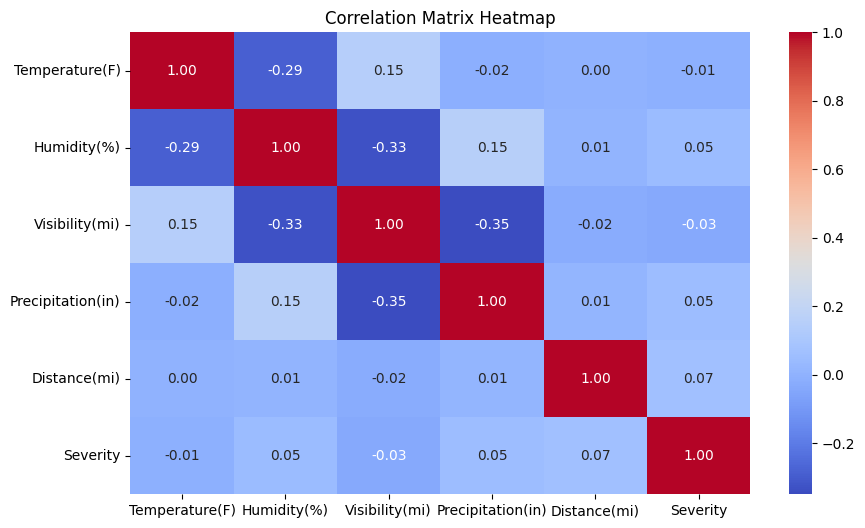

In [9]:
# Select numerical columns for correlation analysis
numerical_columns = ['Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Precipitation(in)', 'Distance(mi)', 'Severity']
correlation_matrix = df[numerical_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()


In [10]:
# Define the columns with missing values
columns_with_missing = ['Precipitation(in)', 'Humidity(%)', 'Temperature(F)', 'Visibility(mi)', 'Weather_Condition']

# 1. Impute 'Precipitation(in)' based on 'Weather_Condition'
df['Precipitation(in)'] = df.groupby('Weather_Condition')['Precipitation(in)'].transform(
    lambda x: x.fillna(x.median())
)

# 2. Impute 'Temperature(F)' based on 'Severity'
df['Temperature(F)'] = df.groupby('Severity')['Temperature(F)'].transform(
    lambda x: x.fillna(x.median())
)

# 3. Impute 'Humidity(%)' based on 'Sunrise_Sunset'
df['Humidity(%)'] = df.groupby('Sunrise_Sunset')['Humidity(%)'].transform(
    lambda x: x.fillna(x.median())
)

# 4. Impute 'Visibility(mi)' based on 'Weather_Condition'
df['Visibility(mi)'] = df.groupby('Weather_Condition')['Visibility(mi)'].transform(
    lambda x: x.fillna(x.median())
)

# 5. Impute 'Weather_Condition' using mode within 'Twilight_Phase'
def fill_mode(series):
    if series.mode().empty:
        return series.fillna('Clear')  # Default to 'Clear' if mode cannot be determined
    else:
        return series.fillna(series.mode()[0])

df['Weather_Condition'] = df.groupby('Twilight_Phase')['Weather_Condition'].transform(fill_mode)

# Verify that missing values are handled
print("Missing values after conditional imputation:")
print(df[columns_with_missing].isnull().sum())

/opt/miniconda3/envs/ml1/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/ml1/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Missing values after conditional imputation:
Precipitation(in)    1575
Humidity(%)             0
Temperature(F)          0
Visibility(mi)       1571
Weather_Condition       0
dtype: int64


In [11]:
# Define the columns with remaining missing values
remaining_missing_columns = ['Precipitation(in)', 'Visibility(mi)']

# Initialize a SimpleImputer with median strategy
median_imputer = SimpleImputer(strategy='median')

# Fit and transform the data
df[remaining_missing_columns] = median_imputer.fit_transform(df[remaining_missing_columns])

# Verify that all missing values are handled
print("Missing values after overall median imputation:")
print(df[remaining_missing_columns].isnull().sum())

# Calculate and display percentage distribution
severity_distribution = df['Severity'].value_counts(normalize=True) * 100
print("\n\nSeverity Distribution (%):\n", severity_distribution)

Missing values after overall median imputation:
Precipitation(in)    0
Visibility(mi)       0
dtype: int64


Severity Distribution (%):
 Severity
2    83.531032
3    13.799505
4     1.739447
1     0.930016
Name: proportion, dtype: float64


Duplicate Distribution by Severity:
Severity
2    251864
3     56011
1      5024
4      3568
Name: count, dtype: int64
Class distribution after removing duplicates in Severity 2:
Severity
2    75.253924
3    20.734973
4     2.613672
1     1.397431
Name: proportion, dtype: float64


/var/folders/80/jbllx5qn3d73pyblcd_7_7800000gn/T/ipykernel_33574/1209471686.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Severity', data=df, palette = "Set2")


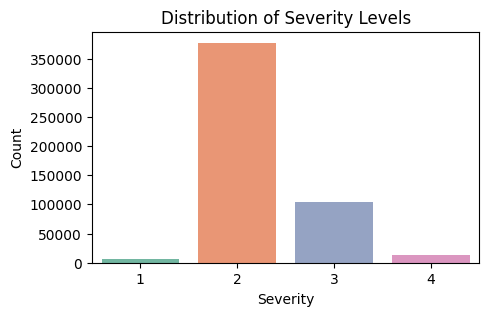

In [12]:
# Check for duplicates across all columns except Severity
duplicates = df[df.duplicated(subset=df.columns.difference(['Severity']), keep=False)]

# Count duplicates by Severity
duplicate_distribution = duplicates['Severity'].value_counts()
print("Duplicate Distribution by Severity:")
print(duplicate_distribution)

# Focus on duplicates in Severity 2
severity_2_duplicates = duplicates[duplicates['Severity'] == 2]

# Remove duplicates from Severity 2 only
df = df.drop(index=severity_2_duplicates.index)

# Verify new class distribution
new_distribution = df['Severity'].value_counts(normalize=True) * 100
print("Class distribution after removing duplicates in Severity 2:")
print(new_distribution)

# Plot the distribution of the target variable
plt.figure(figsize=(5, 3))
sns.countplot(x='Severity', data=df, palette = "Set2")
plt.title('Distribution of Severity Levels')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501134 entries, 0 to 880191
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Severity           501134 non-null  int64  
 1   Distance(mi)       501134 non-null  float64
 2   Temperature(F)     501134 non-null  float64
 3   Humidity(%)        501134 non-null  float64
 4   Visibility(mi)     501134 non-null  float64
 5   Precipitation(in)  501134 non-null  float64
 6   Weather_Condition  501134 non-null  object 
 7   Bump               501134 non-null  bool   
 8   Crossing           501134 non-null  bool   
 9   Junction           501134 non-null  bool   
 10  Stop               501134 non-null  bool   
 11  Traffic_Calming    501134 non-null  bool   
 12  Traffic_Signal     501134 non-null  bool   
 13  Sunrise_Sunset     501134 non-null  object 
 14  Twilight_Phase     501134 non-null  bool   
 15  Give_Way           501134 non-null  bool   
 16  No_Exit

In [14]:

# Separate features and target
X = df.drop(columns=['Severity'])
y = df['Severity']

# One-Hot Encode categorical columns
categorical_columns = ['Weather_Condition', 'Sunrise_Sunset']
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Verify the transformed data
print("Transformed Feature Set:")
print(X.head())

# Check the final shape of features and target
print(f"Feature Set Shape: {X.shape}")
print(f"Target Shape: {y.shape}")


Transformed Feature Set:
    Distance(mi)  Temperature(F)  Humidity(%)  Visibility(mi)  \
0           0.01            80.6         70.0            10.0   
1           0.01            80.6         65.0            10.0   
3           0.01            80.1         69.0            10.0   
7           0.01            78.1         76.0            10.0   
10          0.01            75.9         74.0            10.0   

    Precipitation(in)   Bump  Crossing  Junction   Stop  Traffic_Calming  ...  \
0                 0.0  False     False     False  False            False  ...   
1                 0.0  False     False     False  False            False  ...   
3                 0.0  False     False     False  False            False  ...   
7                 0.0  False     False     False  False            False  ...   
10                0.0  False      True     False  False            False  ...   

    Weather_Condition_Thunder  Weather_Condition_Thunder / Windy  \
0                       False

In [15]:
# Original class distribution
original_distribution = Counter(y)
print("Original Class Distribution:")
print(original_distribution)

# Calculate target distribution for oversampling
# Ensure target samples for each class are >= original counts
severity_2_count = original_distribution[2]
target_distribution = {
    1: int(0.25 * severity_2_count),  # 25% of Severity 2
    3: original_distribution[3],      # Keep Severity 3 unchanged
    4: int(0.2 * severity_2_count),  # 20% of Severity 2
    2: severity_2_count              # Keep Severity 2 unchanged
}

# Apply SMOTE with the updated target distribution
smote = SMOTE(sampling_strategy=target_distribution, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Check new class distribution
new_distribution = Counter(y_smote)
print("\nNew Class Distribution After SMOTE:")
print(new_distribution)

Original Class Distribution:
Counter({2: 377123, 3: 103910, 4: 13098, 1: 7003})

New Class Distribution After SMOTE:
Counter({2: 377123, 3: 103910, 1: 94280, 4: 75424})


In [16]:
# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=42
)

print(f"Training set size: {len(X_train)}, Testing set size: {len(X_test)}")

Training set size: 520589, Testing set size: 130148


In [17]:
# Calculate class weights based on the new class distribution
class_weights = dict(
    y_train.value_counts(normalize=True).apply(lambda x: 1 / x).to_dict()
)

# Train Random Forest with class weights
rf_model = RandomForestClassifier(random_state=42, class_weight=class_weights)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           1     0.9196    0.9229    0.9212     18856
           2     0.8898    0.9458    0.9170     75425
           3     0.8212    0.7257    0.7705     20782
           4     0.8435    0.7095    0.7707     15085

    accuracy                         0.8800    130148
   macro avg     0.8685    0.8260    0.8449    130148
weighted avg     0.8778    0.8800    0.8772    130148


Confusion Matrix:
[[17402   836   518   100]
 [  508 71337  2294  1286]
 [  911  4189 15082   600]
 [  103  3807   472 10703]]


In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate F1 macro score across folds
cv_scores = cross_val_score(
    rf_model, X_smote, y_smote, cv=cv, scoring=make_scorer(f1_score, average='macro')
)

print("Cross-Validation F1 Macro Scores:", cv_scores)
print("Mean F1 Macro Score:", cv_scores.mean())

Cross-Validation F1 Macro Scores: [0.84593578 0.84615624 0.84476544 0.84591438 0.84576742]
Mean F1 Macro Score: 0.845707851073753


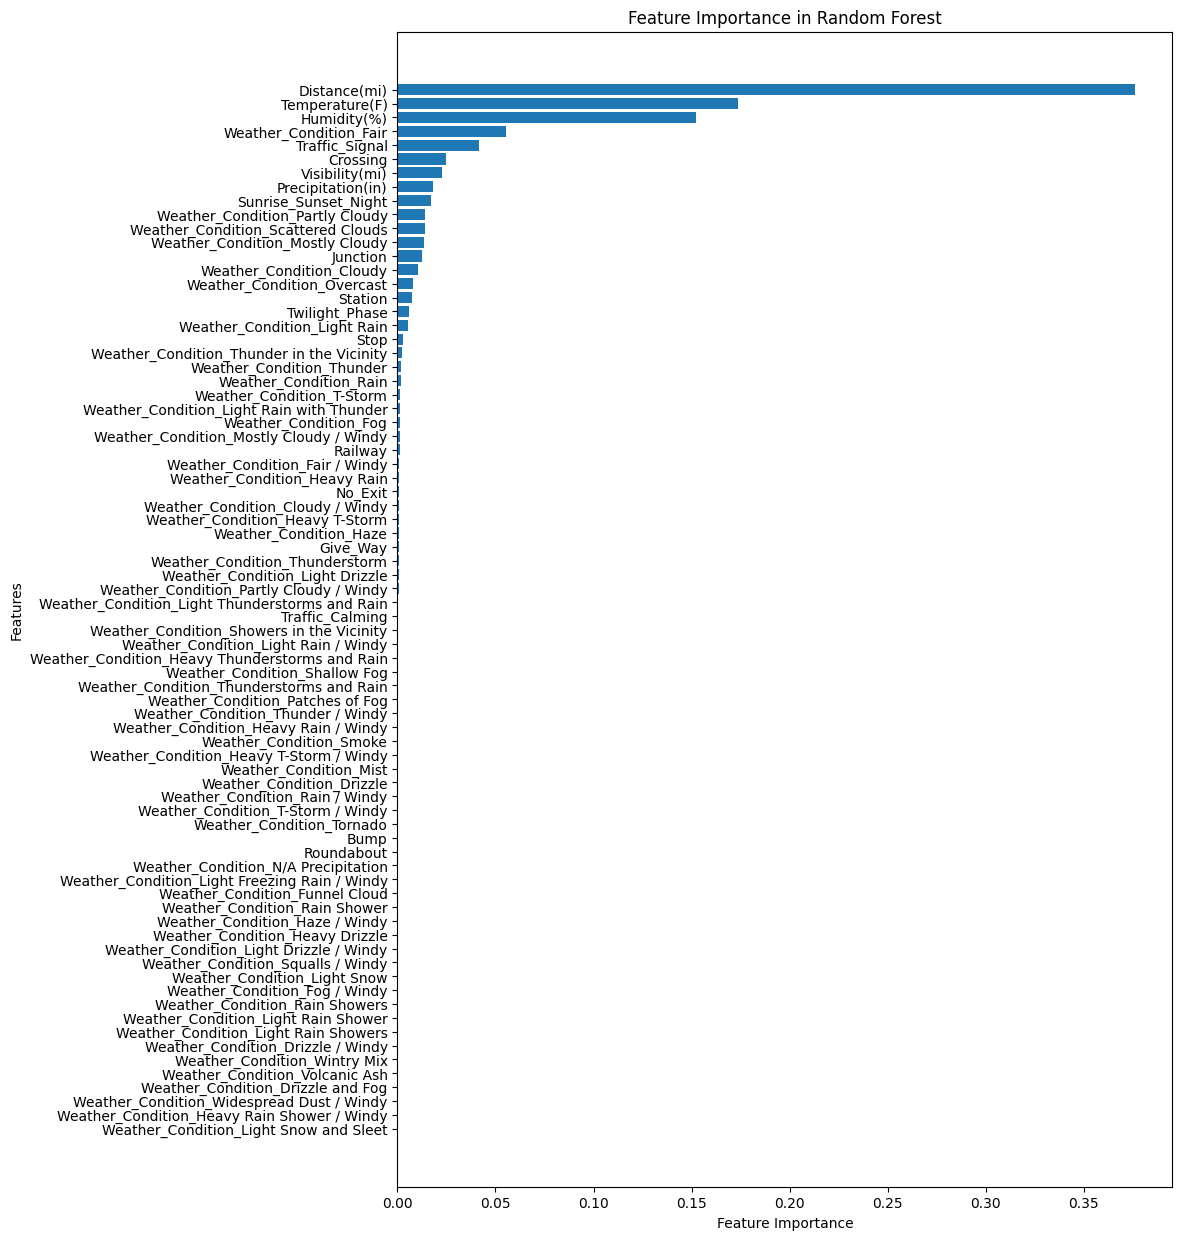

Top 10 Features by Importance:
                            Feature  Importance
0                      Distance(mi)    0.376300
1                    Temperature(F)    0.173625
2                       Humidity(%)    0.152192
22           Weather_Condition_Fair    0.055305
10                   Traffic_Signal    0.041666
6                          Crossing    0.024749
3                    Visibility(mi)    0.022534
4                 Precipitation(in)    0.018239
75             Sunrise_Sunset_Night    0.017126
52  Weather_Condition_Partly Cloudy    0.014027


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 15))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

# Display top features
print("Top 10 Features by Importance:")
print(feature_importances.head(10))
